# Quantitative Trading Strategies Using Python
## Technical Analysis, Statistical Testing,and Machine Learning
—
### Peng Liu

#######################################################################################################################

## CHAPTER 7
## Backtesting a Trading Strategy

### Calculating the Max Drawdown

##### Downloading the stock price data

In [ ]:
!pip install botorch
!pip install -U statsmodels
!pip install ta
!pip install yfinance
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.fit import fit_gpytorch_mll
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import combinations
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import ta
import torch
import torch.nn as nn
import yfinance as yf

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
start_date = "2023-01-01"
end_date = "2023-02-11"
df = yf.download(['GOOG', 'MSFT'], start=start_date, end=end_date)
df.head()

[*********************100%%**********************]  2 of 2 completed


Price       Adj Close                  Close                   High  \
Ticker           GOOG        MSFT       GOOG        MSFT       GOOG   
Date                                                                  
2023-01-03  89.598038  236.609238  89.699997  239.580002  91.550003   
2023-01-04  88.609169  226.259186  88.709999  229.100006  91.239998   
2023-01-05  86.671371  219.553360  86.769997  222.309998  88.209999   
2023-01-06  88.059799  222.140869  88.160004  224.929993  88.470001   
2023-01-09  88.699066  224.303726  88.800003  227.119995  90.830002   

Price                         Low                   Open              \
Ticker            MSFT       GOOG        MSFT       GOOG        MSFT   
Date                                                                   
2023-01-03  245.750000  89.019997  237.399994  89.830002  243.080002   
2023-01-04  232.869995  87.800003  225.960007  91.010002  232.279999   
2023-01-05  227.550003  86.559998  221.759995  88.070000  227.199997   
2023-01-06  225.759995  85.570000  219.350006  87.360001  223.000000   
2023-01-09  231.240005  88.580002  226.410004  89.195000  226.449997   

Price         Volume            
Ticker          GOOG      MSFT  
Date                            
2023-01-03  20738500  25740000  
2023-01-04  27046500  50623400  
2023-01-05  23136100  39585600  
2023-01-06  26612600  43613600  
2023-01-09  22996700  27369800

In [ ]:
df2 = df['Adj Close']

In [ ]:
df2.index

DatetimeIndex(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-17', '2023-01-18', '2023-01-19',
               '2023-01-20', '2023-01-23', '2023-01-24', '2023-01-25',
               '2023-01-26', '2023-01-27', '2023-01-30', '2023-01-31',
               '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06',
               '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
df2.loc["2023-02"]

Ticker,GOOG,MSFT
Date,,
2023-02-01,101.314713,249.615936
2023-02-02,108.676331,261.318970
2023-02-03,105.100403,255.146469
2023-02-06,103.352394,253.586029
2023-02-07,107.917198,264.242310
2023-02-08,99.886337,263.422546
2023-02-09,95.351494,260.351074
2023-02-10,94.752174,259.837585


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28 entries, 2023-01-03 to 2023-02-10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOG    28 non-null     float64
 1   MSFT    28 non-null     float64
dtypes: float64(2)
memory usage: 672.0 bytes


<Axes: xlabel='Date'>

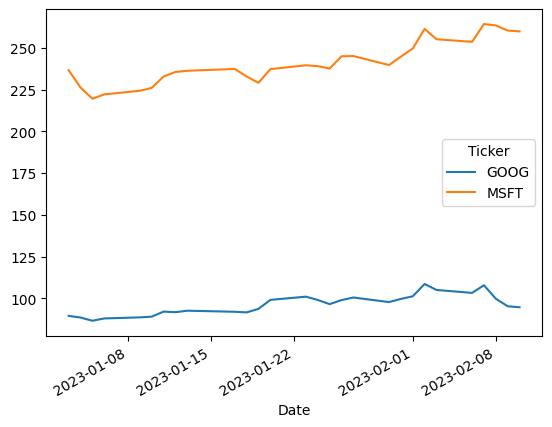

In [ ]:
df2.plot.line()

In [ ]:
returns_df = df2.pct_change()
returns_df.head()

Ticker,GOOG,MSFT
Date,,
2023-01-03,NaN,NaN
2023-01-04,-0.011037,-0.043743
2023-01-05,-0.021869,-0.029638
2023-01-06,0.016019,0.011785
2023-01-09,0.007259,0.009736


<Axes: xlabel='Date'>

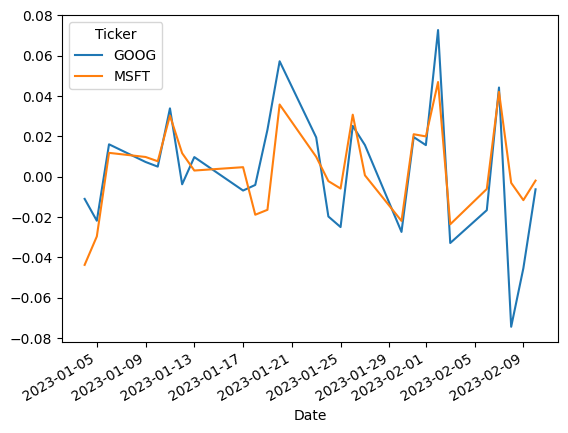

In [ ]:
returns_df.plot.line()

##### Constructing the wealth curve

In [ ]:
initial_wealth = 1000
wealth_index_df = initial_wealth*(1+returns_df).cumprod()
wealth_index_df.head()

Ticker,GOOG,MSFT
Date,,
2023-01-03,NaN,NaN
2023-01-04,988.963277,956.256772
2023-01-05,967.335599,927.915419
2023-01-06,982.831783,938.851210
2023-01-09,989.966616,947.992261


In [ ]:
wealth_index_df.loc["2023-01-03"] = initial_wealth
wealth_index_df.head()

Ticker,GOOG,MSFT
Date,,
2023-01-03,1000.000000,1000.000000
2023-01-04,988.963277,956.256772
2023-01-05,967.335599,927.915419
2023-01-06,982.831783,938.851210
2023-01-09,989.966616,947.992261


<Axes: xlabel='Date'>

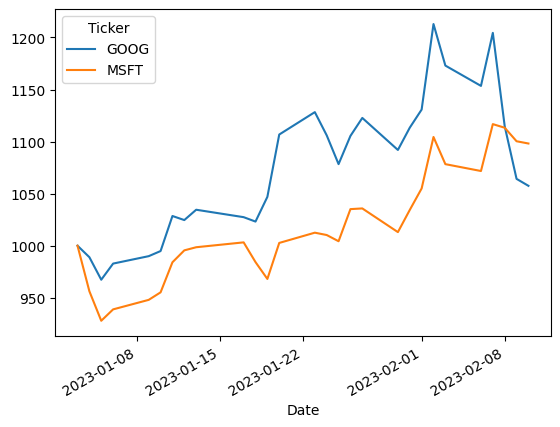

In [ ]:
wealth_index_df.plot.line()

##### Constructing the cumulative maximum wealth

In [ ]:
prior_peaks_df = wealth_index_df.cummax()
prior_peaks_df.head()

Ticker,GOOG,MSFT
Date,,
2023-01-03,1000.0,1000.0
2023-01-04,1000.0,1000.0
2023-01-05,1000.0,1000.0
2023-01-06,1000.0,1000.0
2023-01-09,1000.0,1000.0


<Axes: xlabel='Date'>

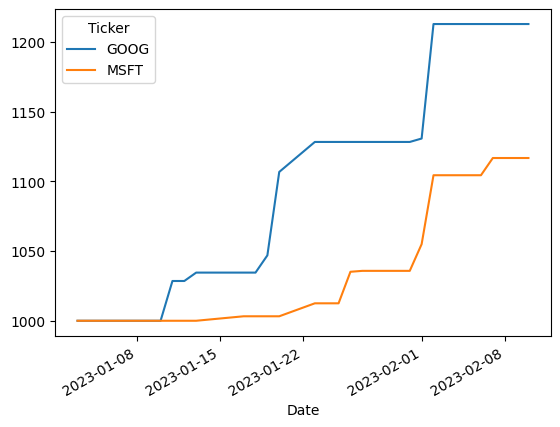

In [ ]:
prior_peaks_df.plot.line()

##### Calculating the daily drawdown

In [ ]:
drawdown_df = (wealth_index_df - prior_peaks_df) / prior_peaks_df
drawdown_df.head()

Ticker,GOOG,MSFT
Date,,
2023-01-03,0.000000,0.000000
2023-01-04,-0.011037,-0.043743
2023-01-05,-0.032664,-0.072085
2023-01-06,-0.017168,-0.061149
2023-01-09,-0.010033,-0.052008


<Axes: xlabel='Date'>

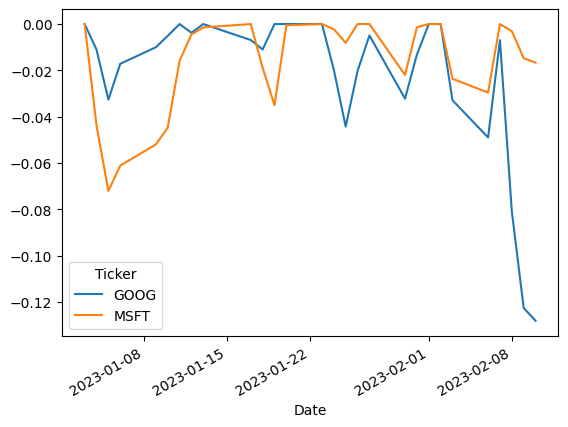

In [ ]:
drawdown_df.plot.line()

##### Calculating the max drawdown

In [ ]:
drawdown_df.min()

Ticker
GOOG   -0.128125
MSFT   -0.072085
dtype: float64

In [ ]:
drawdown_df.idxmin()

Ticker
GOOG   2023-02-10
MSFT   2023-01-05
dtype: datetime64[ns]

In [ ]:
drawdown_df.loc["2023-01"].min()

Ticker
GOOG   -0.044264
MSFT   -0.072085
dtype: float64

In [ ]:
drawdown_df.loc["2023-01"].idxmin()

Ticker
GOOG   2023-01-25
MSFT   2023-01-05
dtype: datetime64[ns]

##### Defining a function to calculate the wealth index, prior peak, and drawdown

In [ ]:
def drawdown(return_series: pd.Series):
    """
    Input: a time series of asset returns
    Output: a DataFrame that contains:
    - the wealth index
    - the prior peaks
    - percentage drawdowns
    """
    wealth_index_series = initial_wealth*(1+return_series).cumprod()
    prior_peaks_series = wealth_index_series.cummax()
    drawdown_series = (wealth_index_series - prior_peaks_series) / prior_peaks_series
    return pd.DataFrame({
    "Wealth index": wealth_index_series,
    "Prior peaks": prior_peaks_series,
    "Drawdown": drawdown_series
    })

In [ ]:
drawdown(returns_df["GOOG"]).head()

,Wealth index,Prior peaks,Drawdown
Date,,,
2023-01-03,NaN,NaN,NaN
2023-01-04,988.963277,988.963277,0.000000
2023-01-05,967.335599,988.963277,-0.021869
2023-01-06,982.831783,988.963277,-0.006200
2023-01-09,989.966616,989.966616,0.000000


<Axes: xlabel='Date'>

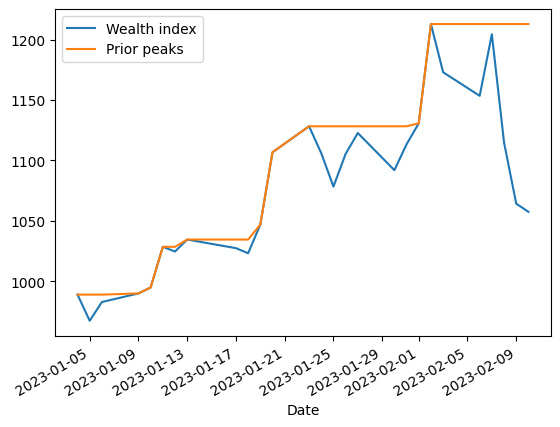

In [ ]:
drawdown(returns_df["GOOG"])[['Wealth index', 'Prior peaks']].plot.line()

<Axes: xlabel='Date'>

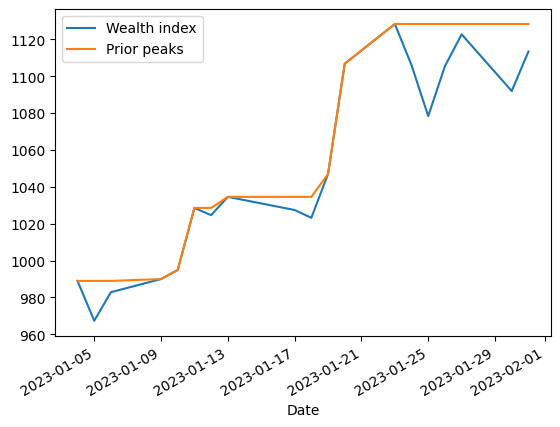

In [ ]:
drawdown(returns_df.loc["2023-01","GOOG"])[['Wealth index', 'Prior peaks']].plot.line()

In [ ]:
drawdown(returns_df["GOOG"])['Drawdown'].min()
drawdown(returns_df["GOOG"])['Drawdown'].idxmin()
drawdown(returns_df["MSFT"])['Drawdown'].min()
drawdown(returns_df["MSFT"])['Drawdown'].idxmin()

Timestamp('2023-01-19 00:00:00')

In [ ]:
drawdown(returns_df.loc["2023-01","GOOG"])['Drawdown'].min()

-0.04426431835618261

In [ ]:
drawdown(returns_df.loc["2023-01","MSFT"])['Drawdown'].min()

-0.03503220376005605

### Backtesting the Trend-Following Strategy

In [ ]:
df_goog = yf.download(['GOOG'], start="2022-01-01", end="2023-01-01")['Adj Close']
df_goog = pd.DataFrame(df_goog)
df_goog.head()

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2022-01-03,144.909592
2022-01-04,144.252350
2022-01-05,137.497040
2022-01-06,137.394653
2022-01-07,136.848770


##### Calculating the short and long moving averages

In [ ]:
sma_span = 30
ema_span = 5
short_ma = 'ema'+str(ema_span)
long_ma ='sma'+str(sma_span)
df_goog[long_ma] = df_goog['Adj Close'].rolling(sma_span).mean()
df_goog[short_ma] = df_goog['Adj Close'].ewm(span=ema_span).mean()
df_goog.head()

,Adj Close,sma30,ema5
Date,,,
2022-01-03,144.909592,NaN,144.909592
2022-01-04,144.252350,NaN,144.515247
2022-01-05,137.497040,NaN,141.190833
2022-01-06,137.394653,NaN,139.613958
2022-01-07,136.848770,NaN,138.552441


In [ ]:
df_goog.dropna(inplace=True)

In [ ]:
import matplotlib.pyplot as plt

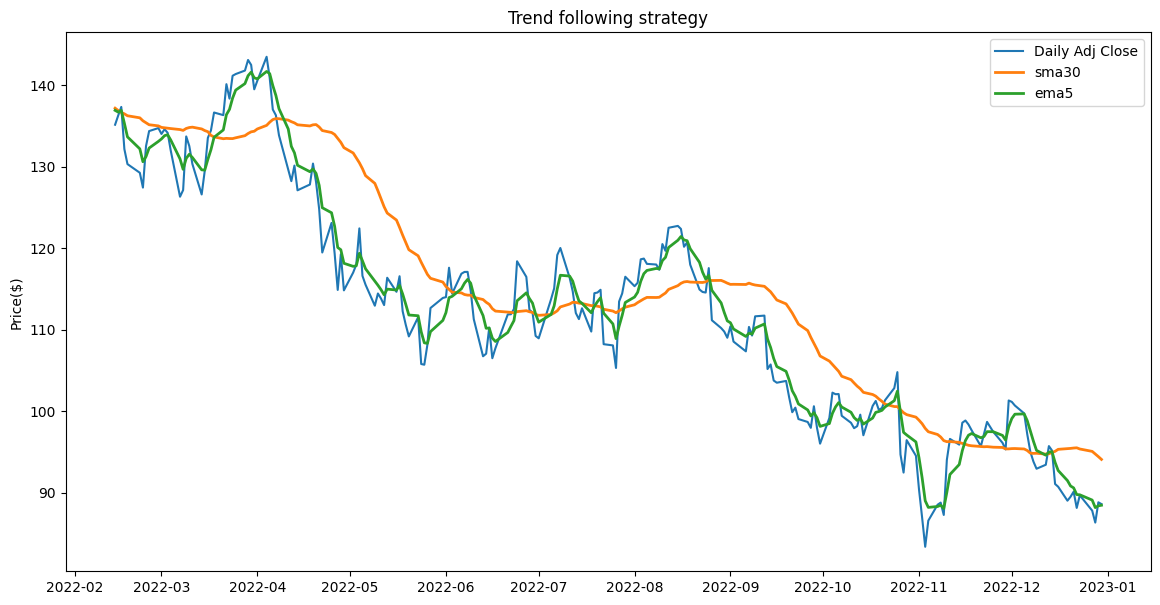

In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(df_goog.index, df_goog['Adj Close'], linewidth=1.5, label='Daily Adj Close')
plt.plot(df_goog.index, df_goog[long_ma], linewidth=2, label=long_ma)
plt.plot(df_goog.index, df_goog[short_ma], linewidth=2, label=short_ma)
plt.title("Trend following strategy")
plt.ylabel('Price($)')
plt.legend()

##### Calculating the log returns of the buy-and-hold strategy

In [ ]:
df_goog['log_return_buy_n_hold'] = np.log(df_goog['Adj Close'] / df_goog['Adj Close'].shift(1))

##### An equivalent way of calculating the log returns

In [ ]:
df_goog['log_return_buy_n_hold'] = np.log(df_goog['Adj Close']).diff()

##### Creating the signal column

In [ ]:
# identify buy signal
df_goog['signal'] = np.where(df_goog[short_ma] > df_goog[long_ma], 1, 0)
# identify sell signal
df_goog['signal'] = np.where(df_goog[short_ma] < df_goog[long_ma], -1, df_goog['signal'])
df_goog.dropna(inplace=True)
df_goog.head()

,Adj Close,sma30,ema5,log_return_buy_n_hold,signal
Date,,,,,
2022-02-15,136.270432,136.891673,136.696001,0.008284,-1
2022-02-16,137.331223,136.660968,136.907742,0.007754,1
2022-02-17,132.158112,136.483004,135.324530,-0.038397,-1
2022-02-18,130.319199,136.247156,133.656084,-0.014012,-1
2022-02-22,129.255417,135.994044,132.189194,-0.008196,-1


##### Calculating the periodic log returns of the buy-and-hold strategy

In [ ]:
df_goog['log_return_trend_follow'] = df_goog['signal'] * df_goog['log_return_buy_n_hold']

##### Calculating terminal returns of both strategies

In [ ]:
# terminal return of buy-n-hold
np.exp(df_goog['log_return_buy_n_hold']).cumprod()[-1] - 1

# another way to calculate
np.exp(df_goog['log_return_buy_n_hold']).prod() - 1


/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_30148/2158012264.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(df_goog['log_return_buy_n_hold']).cumprod()[-1] - 1


-0.34419803132954907

In [ ]:

# terminal return of trend following
np.exp(df_goog['log_return_trend_follow']).cumprod()[-1] -1

# another way to calculate
np.exp(df_goog['log_return_trend_follow']).prod() - 1

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_30148/3491466339.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(df_goog['log_return_trend_follow']).cumprod()[-1] -1


0.36091483998550555

In [ ]:
df_goog

,Adj Close,sma30,ema5,log_return_buy_n_hold,signal,log_return_trend_follow
Date,,,,,,
2022-02-15,136.270432,136.891673,136.696001,0.008284,-1,-0.008284
2022-02-16,137.331223,136.660968,136.907742,0.007754,1,0.007754
2022-02-17,132.158112,136.483004,135.324530,-0.038397,-1,0.038397
2022-02-18,130.319199,136.247156,133.656084,-0.014012,-1,0.014012
2022-02-22,129.255417,135.994044,132.189194,-0.008196,-1,0.008196
...,...,...,...,...,...,...
2022-12-23,89.707916,95.385788,89.768078,0.017409,-1,-0.017409
2022-12-27,87.830055,95.092788,89.122071,-0.021155,-1,0.021155
2022-12-28,86.361725,94.774151,88.201955,-0.016859,-1,0.016859


##### Calculating the annualized return

In [ ]:
# calculate annualized return of buy-n-hold
annualized_return_buy_n_hold = np.exp(df_goog['log_return_buy_n_hold']).prod()**(252/df_goog.shape[0])-1
annualized_return_buy_n_hold

-0.3818823406949291

In [ ]:
# calculate annualized return of trend following
annualized_return_trend_follow = np.exp(df_goog['log_return_trend_follow']).prod()**(252/df_goog.shape[0])-1
annualized_return_trend_follow

0.42103121194126136

Note that we can also add up all the log returns and exponentiate the sum to get the
same result:

In [ ]:
np.exp(df_goog['log_return_trend_follow'].sum())**(252/df_goog.shape[0])-1

0.4210312119412587

##### Calculating the annualized volatility

In [ ]:
# calculate annualized volatility of buy-n-hold
annualized_vol_buy_n_hold = (np.exp(df_goog['log_return_buy_n_hold'])-1).std()*(252**0.5)
annualized_vol_buy_n_hold

0.3896836126348582

In [ ]:

# calculate annualized volatility of trend following
annualized_vol_trend_follow = (np.exp(df_goog['log_return_trend_follow'])-1).std()*(252**0.5)
annualized_vol_trend_follow

0.3928554568061577

##### Calculating the Sharpe ratio

In [ ]:
riskfree_rate = 0.03
# calculate Sharpe ratio of buy-n-hold
sharpe_ratio_buy_n_hold = (annualized_return_buy_n_hold - riskfree_rate) / annualized_vol_buy_n_hold
sharpe_ratio_buy_n_hold


-1.056966029210142

In [ ]:
# calculate Sharpe ratio of trend following
sharpe_ratio_trend_follow = (annualized_return_trend_follow - riskfree_rate) / annualized_vol_trend_follow
sharpe_ratio_trend_follow

0.9953564476875869

##### Calculating the max drawdown

In [ ]:
# max drawdown of buy-n-hold
max_drawdown_buy_n_hold = drawdown(np.exp(df_goog['log_return_buy_n_hold'])-1)['Drawdown'].min()
max_drawdown_buy_n_hold

-0.4187653906097545

In [ ]:
# max drawdown of trend following
max_drawdown_trend_follow = drawdown(np.exp(df_goog['log_return_trend_follow'])-1)['Drawdown'].min()
max_drawdown_trend_follow

-0.20685356966801752

##########################################################################################################################################